# Click-through Prediction For a Company With 28M MAU

*This project is the summary code of my team capstone project at [IE Datascience Bootcamp](https://www.ie.edu/exponential-learning/programs/data-science-bootcamp/).*

My team and I worked in a click-through prediction for a company with 28M MAU to **improve the ad allocation of the company**. The data is propietary and not available but I leave here a summary of all the analysis we did.

### Authors
- [Manuel Alvarez](https://www.linkedin.com/in/manuelalvrod/)
- [Myriam Barnés (me)](https://www.linkedin.com/in/myriambarnes/)
- [Isaque Campinho](https://www.linkedin.com/in/isaque-campinho-72362521/)
- [Tarik Jebbari](https://www.linkedin.com/in/tarik-jebbari/)

## The problem 🤔

Programmatic advertising is the automated transaction of buying and selling advertising online. Ads are displayed with banners in a website and their performance is measured with CTR (Click Throught Rate):

$$CTR=\frac{Clicks}{Impressions}$$

CTR is usually a really low number for ads. If it's a 1% it means that only 1 of every 100 visitors that where exposed to an ad clicked on that ad.

A 60% of the revenue of our company comes from its website banners. Our problem is to rise that revenue as much as possible. **Banners holders get paid by number of clicks and by number of impressions** (a lot less than for clicks). The way to monetize the banners is by selling them in a ads auction where advertisers bid for the banners. There's a lot of providers of auctions. In our case, the website knows it's own users so they have a premium provider of ads for this type of user. These ads gives them more revenue but they are limited because they need prior negotation with the provider.

Imagine the ads are limited to 10M a month. Or limited to a 30% of our standard website traffic a month. We will allocate a 30% of the ads to a premium provider and the other 70% to a standard provider. But, how? How can we optimize the allocation to increase our revenue? This is our challenge.

The goal is to **train a model that sets a probability for a user clicking on an ad**. Then we will sort that probabilities and we will show premium ads to the 30% of users with the highest probability, and for the other 70% we will show standard ads. We will measure the performance of our model with a metric called [lift](https://en.wikipedia.org/wiki/Lift_(data_mining)).

The lift of a group is how many times is better or worse a group of the data compared to the average:

$$Lift=\frac{P_{i}(click)}{P(click)}$$

where $i$ is the number of decile or group. Then we will calculate **how much can we improve the revenue** with our model and compare it with not having any model.

Let's start!!

## Import the libraries and the data 📡

We're importing here only the libraries needed for data visualization and data wrangling. We will import later the one needed for the ml models.

Then, we read the dataframes and found that we have **1M rows in each and 10 different features**:

- Impression_Key: A unique number for every row.
- Ad_Unit_Name: The name of the ad.
- Date: The date of the impression.
- time2: The time of the impression recorded by the company server (same timezone for every country)
- Country: The country of the impression.
- Site: Which country extension is the website (on UK you can see the webpage of Spain).
- OS: The operating system of the user doing the impression.
- Browser: The browser used by the user doing the impression.
- RefererURL: In which part of the website the person was when clicking the ad.

- Clicks: 1 if click, 0 for not click.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import re
from copy import  deepcopy
from IPython.display import display
from sklearn.utils import shuffle

#custom library
from ourtools import map_encoder_categorical, map_encoder_fit,map_encoder_transform #credits to @frandiego
from ourtools import visual, undersample, apply_models

#ignore warnings for better viz
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_oct=pd.read_csv('IE_project_dataset_oct.csv')
df_nov=pd.read_csv('IE_project_dataset_nov.csv')

In [3]:
df_oct.columns

Index(['Impression_Key', 'Ad_Unit_Name', 'Date', 'time2', 'Country', 'Site',
       'OS', 'Browser', 'RefererURL', 'Clicks'],
      dtype='object')

In [4]:
df_oct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054260 entries, 0 to 1054259
Data columns (total 10 columns):
Impression_Key    1054260 non-null object
Ad_Unit_Name      1054260 non-null object
Date              1054260 non-null object
time2             1054260 non-null object
Country           1054260 non-null object
Site              1054260 non-null object
OS                1054260 non-null object
Browser           1054260 non-null object
RefererURL        1054260 non-null object
Clicks            1054260 non-null int64
dtypes: int64(1), object(9)
memory usage: 80.4+ MB


In [5]:
df_oct.nunique()

Impression_Key    1051026
Ad_Unit_Name          148
Date                   31
time2               86144
Country                 5
Site                   33
OS                     17
Browser                43
RefererURL          91240
Clicks                  2
dtype: int64

## Data visualization 📺

We first get rid of "Null" values and normalize columns names. Then we found that **our sample is unbalanced**: we have 5% of clicks and 95% of no clicks.

In [6]:
df=df_oct[df_oct['RefererURL']!='Null']

In [7]:
df.columns=[x.lower() for x in df.columns]

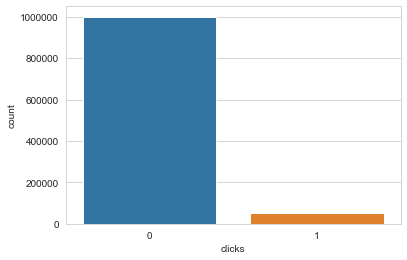

In [8]:
#first check the target
sns.set_style('whitegrid')
sns.countplot(x='clicks',data=df)#,palette='RdBu_r')
plt.show()

### Date and time by country

We first create the *timstamp* column including the date and the time. And then we separate in hour, weekday and date to create visualizations. We also created a new variable *timezone* to normalize the hour for every country.

In [9]:
df['timestamp']=df.apply(lambda x: str(x['date'])+' '+str(x['time2']),axis=1)
df['timestamp']=pd.to_datetime(df['timestamp'])

In [10]:
df['hour']=df['timestamp'].dt.hour
df['weekday']=df['timestamp'].dt.weekday
df['date']=df['timestamp'].dt.date
df.loc[df['country']=='Italy','timezone']=1
df.loc[df['country']=='Spain','timezone']=1
df.loc[df['country']=='United Kingdom','timezone']=0
df.loc[df['country']=='United States','timezone']=-5
df.loc[df['country']=='Canada','timezone']=-5

df['new_hour']=(df['hour']-2+df['timezone']).astype(int)%24

First visualization aim to see the **frecuency of impressions and clicks during the day for every country**. Then we use a heatmap to see which hour of everyday have more visitors. In both charts we find that **working hours are the hours with the highest traffic**. In the right chart we can also find that this tendency is repeated over the week, but not on weekends.

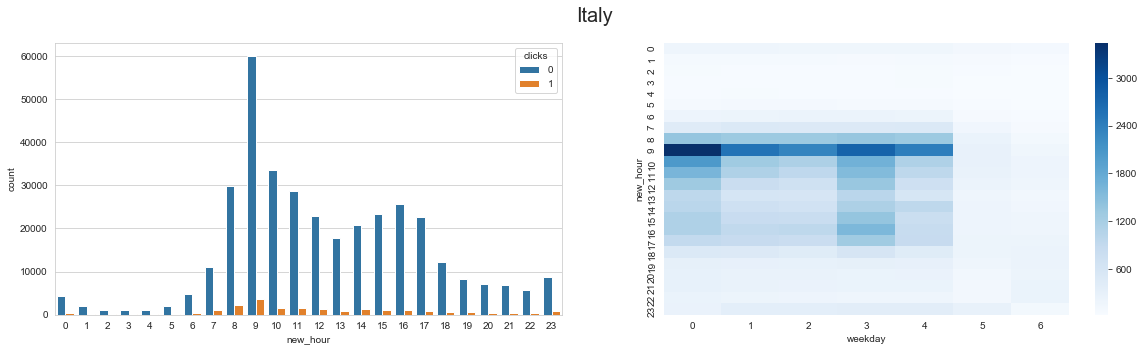

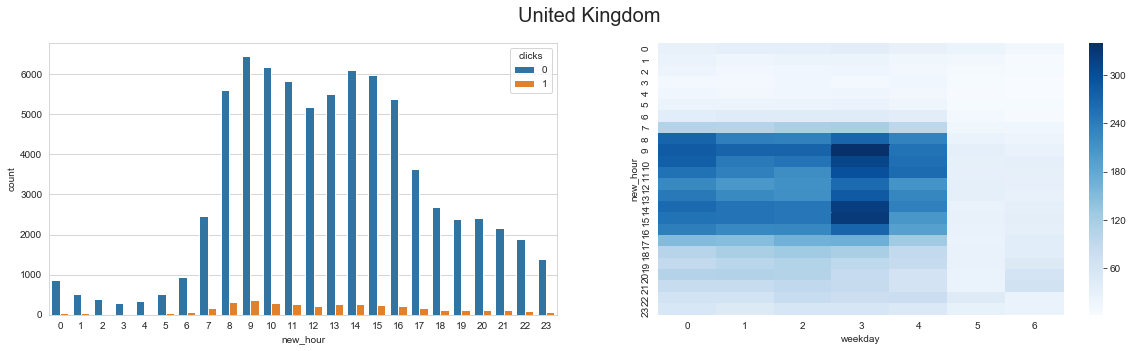

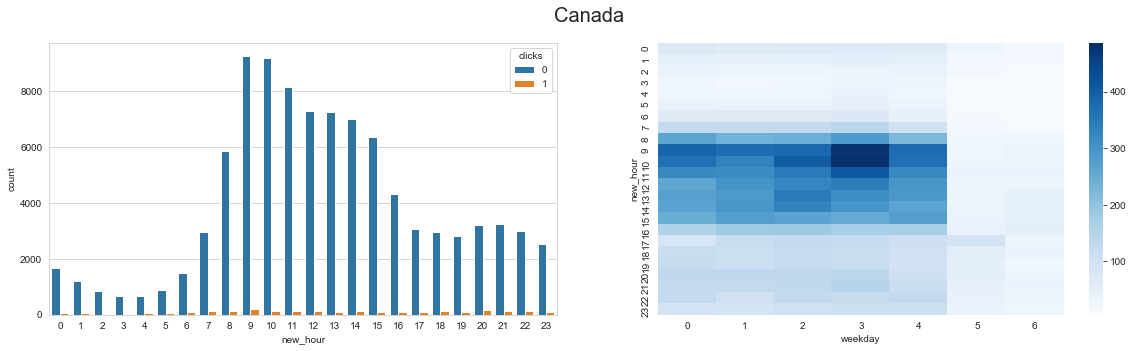

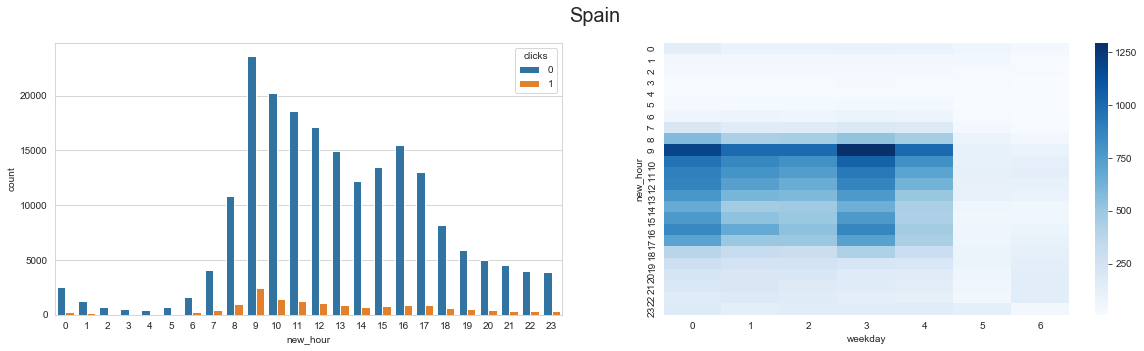

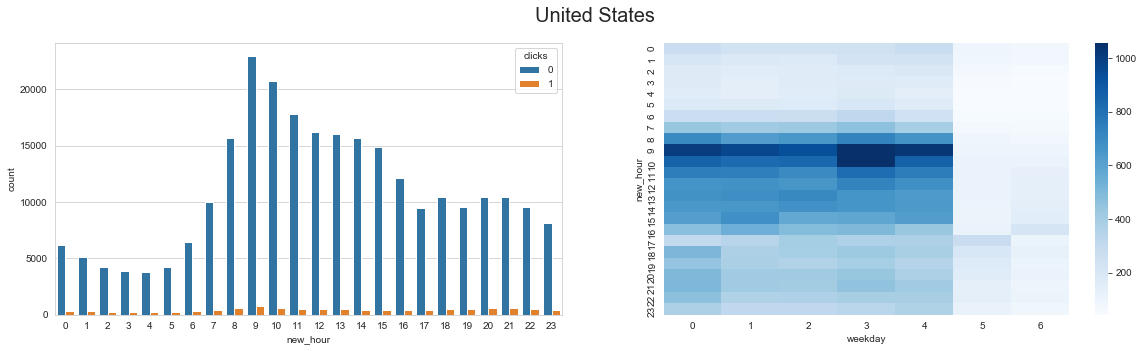

In [11]:
for country in df['country'].unique():
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
    
    #plot a barchart
    sns.countplot(x='new_hour',data=df[df['country']==country],hue='clicks',ax=ax1)
    #ax1.title(country)
    
    #plot a heatmap
    dat=df[df['country']==country]
    heatmap=dat.groupby(['new_hour','weekday','date'])[['clicks']].sum().reset_index().groupby(['new_hour','weekday'])[['clicks']].mean()
    heatmap['impressions']=dat.groupby(['new_hour','weekday','date'])[['clicks']].count().reset_index().groupby(['new_hour','weekday'])[['clicks']].mean()
    heatmap['total']=heatmap['clicks']/heatmap['impressions']
    #plt.figure(figsize=(10,10))
    sns.heatmap(heatmap['impressions'].unstack(),annot=False,fmt='0.0f',ax=ax2,cmap="Blues")
    #ax2.set_xlabel('hour')
    #ax2.set_ylabel('weekday')
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    ax2.set_ylim(b, t) # update the ylim(bottom, top) values
    #ax2.title(country)
    fig.suptitle(country,fontsize=20)
    
    
    plt.show()

In the next visualizations we see the seasonality for different frequencies: hourly and daily. We also ploted the CTR for every hour. We can see that in **hours with less frequency have more clicks in percentage**.

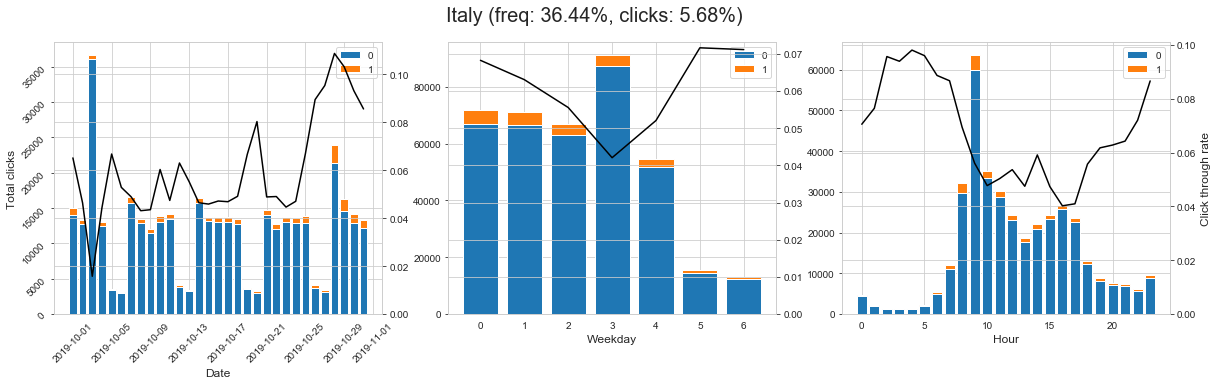

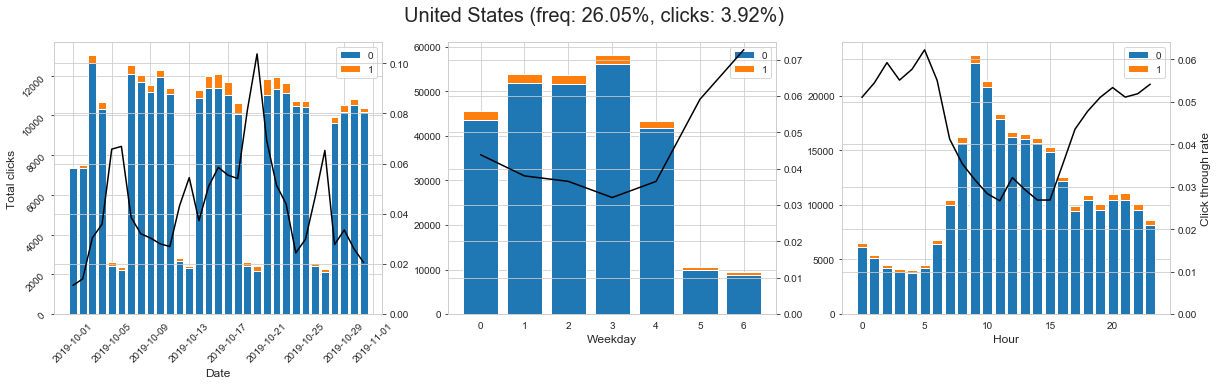

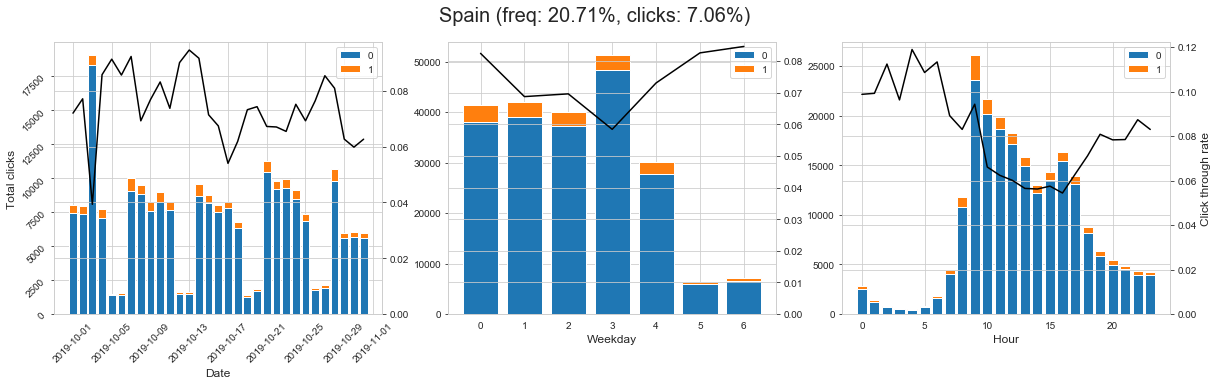

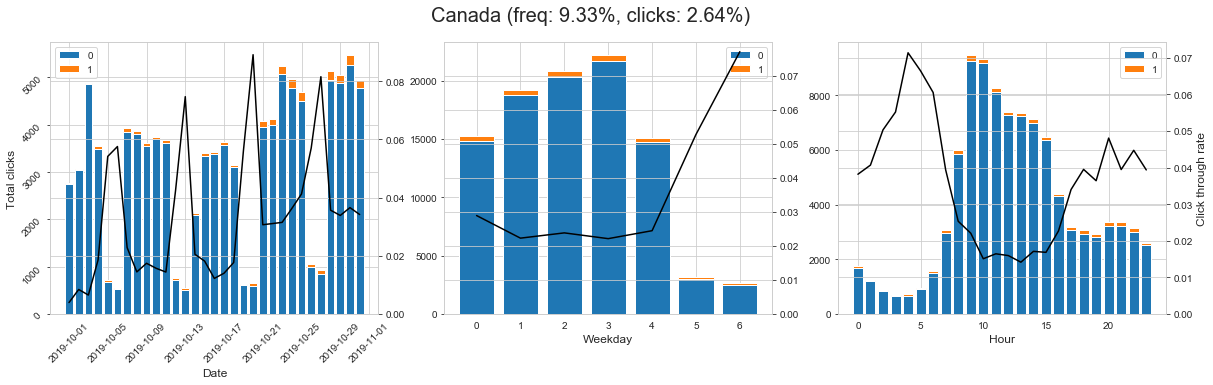

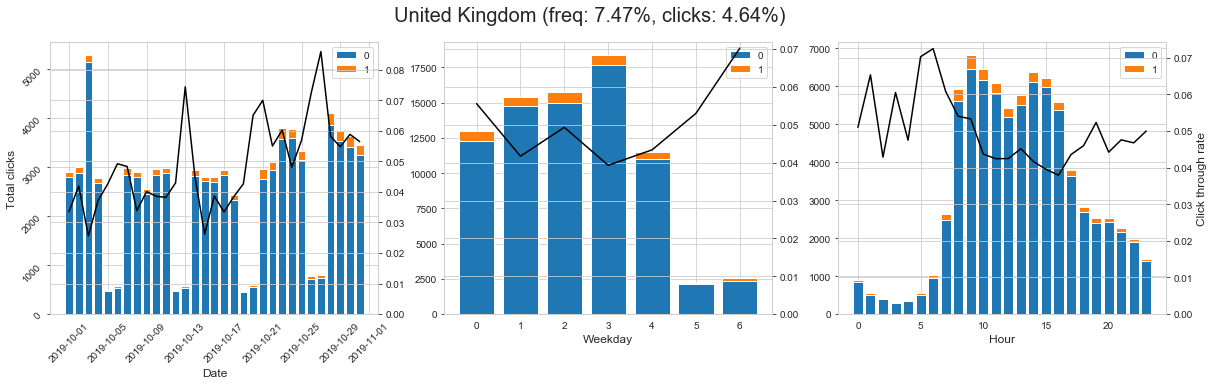

In [12]:
countries=df.groupby(['country','clicks'])[['date']].count()
countries=countries['date'].unstack()
countries['total']=countries[0]+countries[1]
countries[0]=countries[0]/countries['total']
countries[1]=countries[1]/countries['total']
countries['total']=countries['total']/countries['total'].sum()
countries=countries.sort_values('total',ascending=False)
lista_paises=countries.index
countries=countries.to_dict()

for country in lista_paises:
    fig, (ax1, ax3, ax5) = plt.subplots(1, 3,figsize=(20,5))
    dat=df[df['country']==country]

    new=dat.groupby(['date','clicks'])[['country']].count()
    new=new['country'].unstack()
    new['total']=new[0]+new[1]
    ax2 = ax1.twinx()
    ax1.bar(new.index,new[0],label='0')
    ax1.bar(new.index,new[1],bottom=new[0],label='1')
    ax2.plot(new.index,new[1]/new['total'],'k')
    ax1.set_ylabel('Total clicks',fontsize=12)
    ax2.set_ylim(ymin=0)
    #ax2.set_ylabel('Click through rate')
    ax1.set_xlabel('Date',fontsize=12)
    ax1.tick_params(labelrotation=45)
    ax1.legend()
    
    new2=dat.groupby(['weekday','clicks'])[['country']].count()
    new2=new2['country'].unstack()
    new2['total']=new2[0]+new2[1]
    ax4 = ax3.twinx()
    ax3.bar(new2.index,new2[0],label='0')
    ax3.bar(new2.index,new2[1],bottom=new2[0],label='1')
    ax4.plot(new2.index,new2[1]/new2['total'],'k')
    ax4.set_ylim(ymin=0)
    #ax3.set_ylabel('Total clicks')
    #ax4.set_ylabel('Click through rate')
    ax3.set_xlabel('Weekday',fontsize=12)
    ax3.legend()
    
    new3=dat.groupby(['new_hour','clicks'])[['country']].count()
    new3=new3['country'].unstack()
    new3['total']=new3[0]+new3[1]
    ax6 = ax5.twinx()
    ax5.bar(new3.index,new3[0],label='0')
    ax5.bar(new3.index,new3[1],bottom=new3[0],label='1')
    ax6.plot(new3.index,new3[1]/new3['total'],'k')
    #ax5.set_ylabel('Total clicks')
    ax6.set_ylabel('Click through rate',fontsize=12)
    ax6.set_ylim(ymin=0)
    ax5.set_xlabel('Hour',fontsize=12)
    ax5.legend()
    
    fig.suptitle('{} (freq: {:1.2%}, clicks: {:1.2%})'.format(country,countries['total'][country],
                                                                 countries[1][country]),fontsize=20)
    plt.show()

Those charts encourage us to make the decision of **changing the variables** *timestamp* for *weekend*: if it's weekend or not, and *working hours*: if it's working hour or not. With these changes we maybe lost some information but have more insightfull and less complex variables.

### Segment by device

We encoded the os system to know which device was being used. We found that mostly came from a computer.

In [13]:
df.loc[df['os'].isin(['Microsoft Windows 10', 'Microsoft Windows 7', 'Macintosh',
           'Microsoft Windows XP', 'Microsoft Windows 8', 'Unix',
           'Linux','Microsoft Windows Vista',
           'Microsoft Windows Unknown Version', 'Microsoft Windows 2000',
           'Microsoft Windows NT']),'device']='Computer'
df.loc[df['os'].isin(['Apple iOS','Android', 'WindowsPhone']),'device']='Phone'
df.loc[df['os'].isin(['Xbox One', 'Playstation4','Other/Unknown']),'device']='Other'

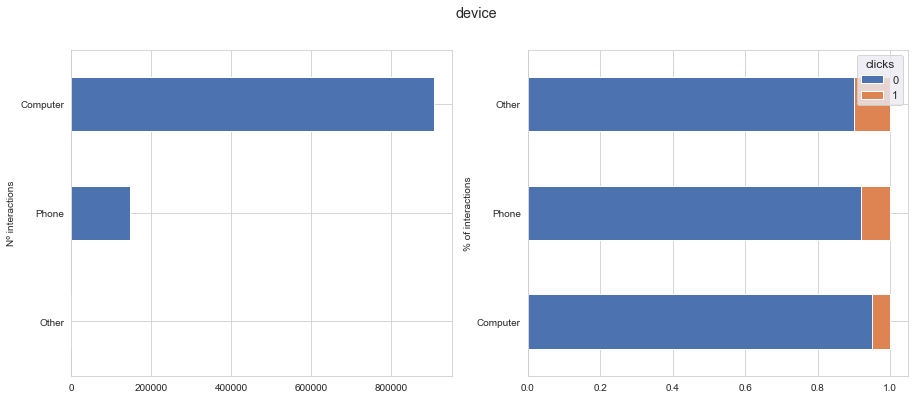

In [14]:
visual('device',df)

### Segment by OS type
The segmentation before was maybe too much but OS is still broader, so we created a new os_type leaving only the name of the operative system (not the version).

In [15]:
df['os_type']='Other'
df.loc[(df['device']=='Computer')|
       (df['device']=='Phone'),'os_type']=df['os'].apply(lambda x: x.split()[0])

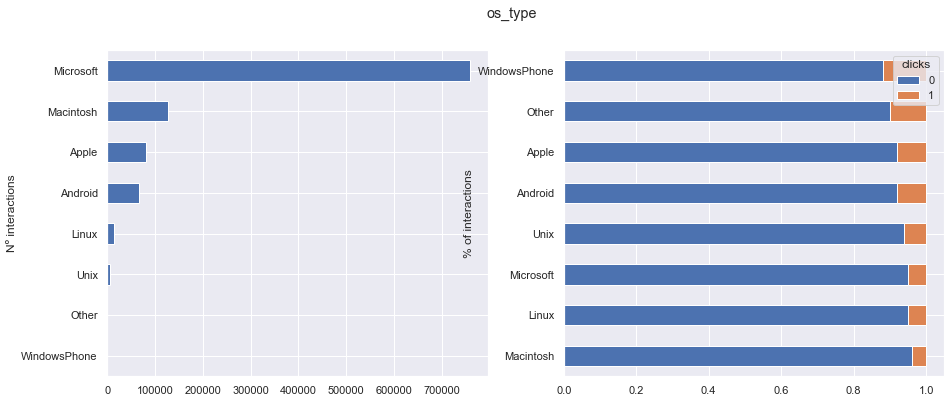

In [16]:
visual('os_type',df)

### Segment by ad type

We also got the *ad_name* from the *ad_unit* code, finding only 6 different types of ads. There're 4 types more common than the other two, and these other two don't have any click.

In [17]:
df['ad_name']=df['ad_unit_name'].apply(lambda x: x[6:])

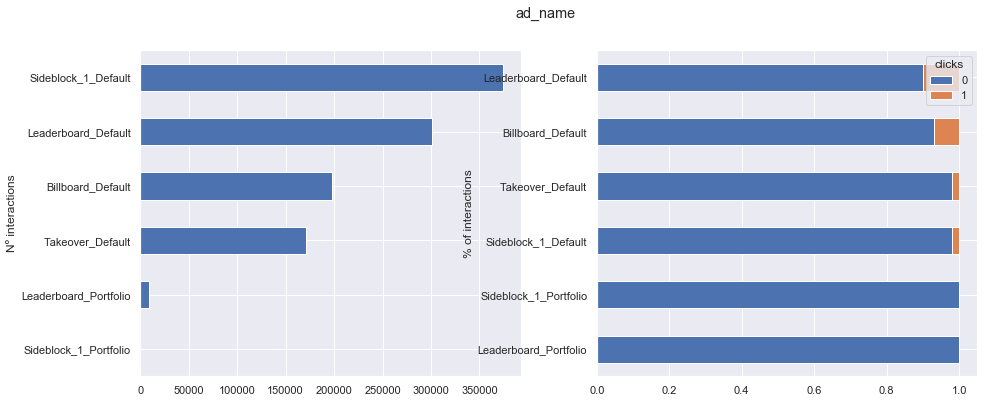

In [18]:
visual('ad_name',df)

### Segment by country

We've played with the countries before, but here we found that we only have 5 different countries and the CTR is similar inside them.

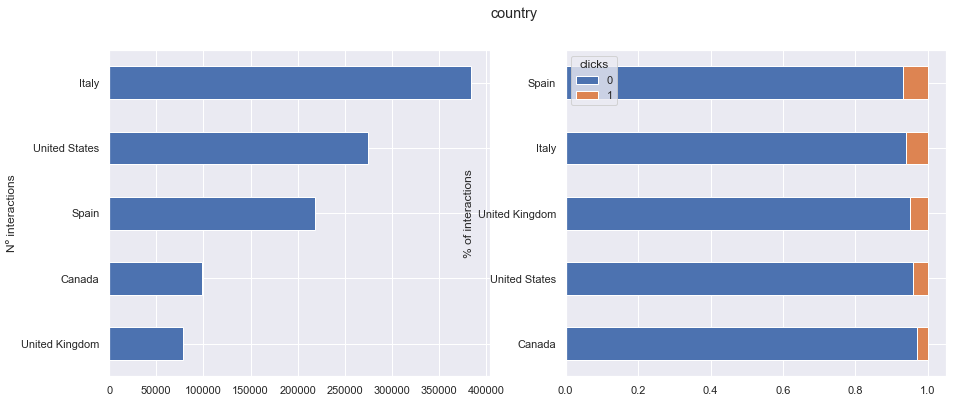

In [19]:
visual('country',df)

### Segment by website

We had lot of different pages inside the website. To create insigtfull variables we got only the first *page* in which the user was inside the website. Then we see the percentage of impressions in which it appear and discover that **the 10th most common page only appears in a 1.5% of the rows**.

We will only use the top pages and put others under *other* category.

In [20]:
# play with the url
df['url']=df['refererurl'].apply(lambda x: x.replace('https://','').replace('http://',''))
lines=df['url'].str.extract('(\w+\.\w+\.\w+)', expand=False)
lines[lines.isna()]=df['url'].str.extract('(\w+)', expand=False)
lines=pd.DataFrame(lines).rename(columns={'url':'first_url'})
lines['second_url']=df['url'].str.extract('\w+\.\w+\.\w+/(\w+)', expand=False)
lines.loc[lines['second_url'].isna(),'second_url']=df['url'].str.extract('\w+/(\w+)', expand=False)
lines['second_url']=lines['second_url'].fillna('main_page')


dat=pd.concat([df[['clicks','date']],lines],axis=1)


In [21]:
dat['second_url'].value_counts(normalize=True).head(20)

equities       0.303464
indices        0.215194
commodities    0.115581
main_page      0.095908
currencies     0.054099
portfolio      0.045183
economic       0.034723
news           0.033478
rates          0.016528
crypto         0.015307
etfs           0.014613
markets        0.011280
analysis       0.008989
charts         0.008904
technical      0.008607
members        0.005445
search         0.002700
earnings       0.002074
funds          0.001914
stock          0.001483
Name: second_url, dtype: float64

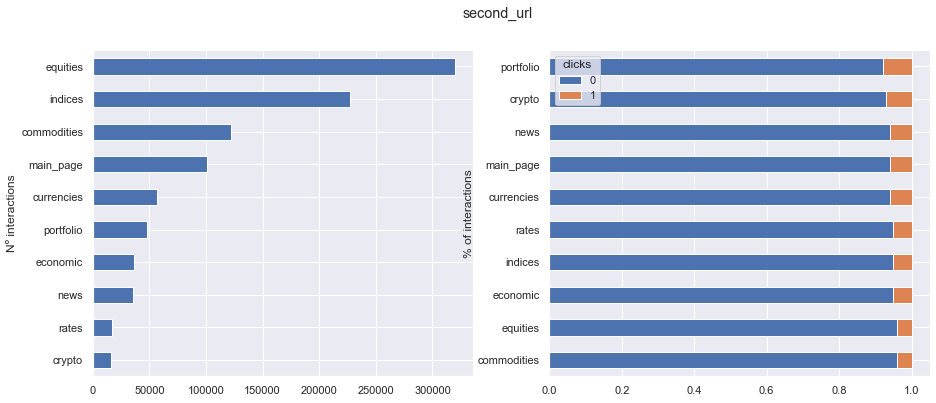

In [22]:
lista=list(dat['second_url'].value_counts().head(10).index)
visual('second_url',dat[dat['second_url'].isin(lista)])

## Feature engineering ⚙️

We created a *feature_engineering* function to **apply all the changes we found important in the data visualization**. This function is specific for this case and involves every change we do to clean the dataset and get more insighful categories.

In [23]:
def feature_engineering(dataset):
    df=deepcopy(dataset)
    
    ### CREATE NEW FEATURES
    df=df[df['RefererURL']!='Null']
    
    # play with date and time
    df['Date']=pd.to_datetime(df['Date'])
    df['Weekday']=df['Date'].dt.weekday
    df['Date']=df['Date'].dt.date
    df['hour']=df['time2'].apply(lambda x: int(x[:2]))
    
    
    df['server_datetime']=df.apply(lambda x: str(x['Date'])+' '+str(x['time2']),axis=1)
    df['server_datetime']=pd.to_datetime(df['server_datetime'])

    df.loc[df['Country']=='Italy','timezone']=1
    df.loc[df['Country']=='Spain','timezone']=1
    df.loc[df['Country']=='United Kingdom','timezone']=0
    df.loc[df['Country']=='United States','timezone']=-5
    df.loc[df['Country']=='Canada','timezone']=-5

    df['new_hour']=(df['hour']-2+df['timezone']).astype(int)%24
    
    # play with the operative system, browser and device
    df.loc[df['OS'].isin(['Microsoft Windows 10', 'Microsoft Windows 7', 'Macintosh',
           'Microsoft Windows XP', 'Microsoft Windows 8', 'Unix',
           'Linux','Microsoft Windows Vista',
           'Microsoft Windows Unknown Version', 'Microsoft Windows 2000',
           'Microsoft Windows NT']),'Device']='Computer'
    df.loc[df['OS'].isin(['Apple iOS','Android', 'WindowsPhone']),'Device']='Phone'
    df.loc[df['OS'].isin(['Xbox One', 'Playstation4','Other/Unknown']),'Device']='Other'

    df['OS_type']='Other'
    df.loc[(df['Device']=='Computer')|(df['Device']=='Phone'),'OS_type']=df['OS'].apply(lambda x: x.split()[0])

    df['Browser_type']=df['Browser'].apply(lambda x: ' '.join(x.split()[:-1]))
    df['Browser_type']=df['Browser_type'].apply(lambda x: 'Safari' if 'Safari' in x else x)
    df['Browser_type']=df['Browser_type'].apply(lambda x: 'Firefox' if 'Firefox' in x else x)
    df['Browser_type']=df['Browser_type'].apply(lambda x: 'Chrome' if 'Google' in x else x)
    df['Browser_type']=df['Browser_type'].apply(lambda x: 'Explorer' if 'Microsoft' in x else x)
    df.loc[~df['Browser_type'].isin(['Safari','Firefox','Chrome','Explorer']),'Browser_type']='Other'
    
    # play with the ad
    df['Ad_Name']=df['Ad_Unit_Name'].apply(lambda x: x[6:])
    df['Ad_Type']=df['Ad_Unit_Name'].apply(lambda x: x.split('_')[-1])
    df['Ad_Place']=df['Ad_Name'].apply(lambda x: x.split('_')[0])

    
    # play with the url
    df['URL']=df['RefererURL'].apply(lambda x: x.replace('https://','').replace('http://',''))
    lines=df['URL'].str.extract('(\w+\.\w+\.\w+)', expand=False)
    lines[lines.isna()]=df['URL'].str.extract('(\w+)', expand=False)
    lines=pd.DataFrame(lines).rename(columns={'URL':'First_URL'})
    lines['Second_URL']=df['URL'].str.extract('\w+\.\w+\.\w+/(\w+)', expand=False)
    lines.loc[lines['Second_URL'].isna(),'Second_URL']=df['URL'].str.extract('\w+/(\w+)', expand=False)
    lines['Second_URL']=lines['Second_URL'].fillna('main_page')


    df=pd.concat([df[['Clicks','Country','OS_type','time2','Date',
                      'Browser_type','Weekday','hour','Ad_Name','Ad_Place',
                      'Device','URL','server_datetime']].rename(columns={'time2':'time'}),lines],axis=1)

    df.columns=[x.lower() for x in df.columns]

    #select features
    chosen_websites=list((df['second_url'].value_counts()/len(df)).head(10).index)
    df.loc[~df['second_url'].isin(chosen_websites),'second_url']='other'

    df['weekend']=0
    df.loc[df['weekday']<5,'weekend']=1

    df['work_hours']=0
    df.loc[(df['hour']<19)&(df['hour']>7)&(df['weekend']==0),'work_hours']=1

    df['new_ad_name']=df['ad_name']
    df.loc[(df['ad_name']=='Leaderboard_Default') | (df['ad_name']=='Billboard_Default'),'new_ad_name']='Header'
    #df.loc[(df['ad_name']=='Leaderboard_Portfolio') | (df['ad_name']=='Sideblock_1_Portfolio'),'new_ad_name']='Portfolio'

    
    df.loc[~df['os_type'].isin(['Microsoft','Macintosh','Apple','Android']),'os_type']='Other'
    
    
    return df[['server_datetime','date','weekday','weekend','hour','work_hours','country','os_type','browser_type','device',
               'second_url','ad_name','ad_place','new_ad_name','clicks']].rename(columns={'second_url':'url_impression'})


In [24]:
df_oct_better=feature_engineering(df_oct)
df_nov_better=feature_engineering(df_nov)

## Model preparation 🧪

Once the data is clean we created **a function to undersample it before applying the algorithms**. It's a function that divides the data in a balanced dataset for training and an unbalanced dataset (proportion specified) for testing. Then we concat the two dataframes of the two months, select the features and encode categorical ones.

In [25]:
label='clicks'
df_oct_train,df_oct_test,lost1,lost11=undersample(df_oct_better,label,proportion_test=0.05)
df_nov_train,df_nov_test,lost2,lost12=undersample(df_nov_better,label,proportion_test=0.05)

In [26]:
df_train=shuffle(pd.concat([df_oct_train,df_nov_train],axis=0)).reset_index(drop=True)
df_test=shuffle(pd.concat([df_oct_test,df_nov_test],axis=0)).reset_index(drop=True)

In [27]:
df_train.head()

,server_datetime,date,weekday,weekend,hour,work_hours,country,os_type,browser_type,device,url_impression,ad_name,ad_place,new_ad_name,clicks
0,2019-11-04 11:04:07,2019-11-04,0,1,11,0,Italy,Microsoft,Chrome,Computer,equities,Leaderboard_Default,Leaderboard,Header,1
1,2019-10-25 11:30:10,2019-10-25,4,1,11,0,Italy,Microsoft,Explorer,Computer,economic,Takeover_Default,Takeover,Takeover_Default,0
2,2019-10-25 22:40:54,2019-10-25,4,1,22,0,Canada,Microsoft,Chrome,Computer,main_page,Sideblock_1_Default,Sideblock,Sideblock_1_Default,0
3,2019-10-28 17:50:05,2019-10-28,0,1,17,0,Italy,Microsoft,Chrome,Computer,indices,Sideblock_1_Default,Sideblock,Sideblock_1_Default,0
4,2019-11-15 11:10:44,2019-11-15,4,1,11,0,Italy,Microsoft,Chrome,Computer,other,Leaderboard_Default,Leaderboard,Header,0


In [28]:
len(df_train)

178258

In [29]:
len(df_test)

207898

After feature engineering and some iterations of the ml algorithms, we decided these where the **best features to include in our model**.

In [30]:
cat_feat=['os_type','browser_type','url_impression','new_ad_name','country']
num_feat=['weekend','work_hours']
label='clicks'

X_train=df_train[cat_feat+num_feat]
X_test=df_test[cat_feat+num_feat]
y_train=df_train[label]
y_test=df_test[label]

In [31]:
encoder=map_encoder_fit(X_train,cat_feat)
X_train_trf=map_encoder_transform(X_train,encoder)
X_test_trf=map_encoder_transform(X_test,encoder)

## Model Building and Evaluation ⏳

We **automate model fit and evaluation** with the function *apply_models*. The first parameter is a dict of models object we want to apply for the data. The output is two dataframes with the most relevant metrics and the feature importance for every model.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,cohen_kappa_score,precision_score,recall_score,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB


models={
    'logmodel':LogisticRegression(random_state=101),
    'decisiontree':DecisionTreeClassifier(),
    'randomforest':RandomForestClassifier(),
    'adamodel':AdaBoostClassifier(n_estimators=10,random_state=101),
    'xgbmodel':XGBClassifier(random_state=101),
    'gradientmodel':GradientBoostingClassifier(n_estimators=10,random_state=101),
    'lightmodel':LGBMClassifier(random_state=101),
    'catmodel':CatBoostClassifier(silent=True,random_state=101),
    'naivebayes':MultinomialNB()
}

In [33]:
df_metrics,feature_imp=apply_models(models,X_train_trf,y_train,X_test_trf,y_test)
display(df_metrics)
display(feature_imp)

logmodel
decisiontree
randomforest
adamodel
xgbmodel
gradientmodel
lightmodel
catmodel
naivebayes


,logmodel,decisiontree,randomforest,adamodel,xgbmodel,gradientmodel,lightmodel,catmodel,naivebayes
accuracy,0.537922,0.641916,0.637745,0.578077,0.608015,0.577644,0.632858,0.639972,0.572877
cohen_kappa,0.059156,0.088851,0.088066,0.069047,0.081890,0.073466,0.088446,0.090053,0.058740
roc_auc,0.686144,0.748112,0.749132,0.715839,0.746987,0.730123,0.753715,0.753728,0.675311


,imp_decisiontree,imp_randomforest,imp_adamodel,imp_xgbmodel,imp_gradientmodel,imp_lightmodel,imp_catmodel
variable,,,,,,,
os_type,0.147092,0.126672,0.1,0.157051,0.141029,451,14.129575
browser_type,0.050481,0.059277,0.2,0.055306,0.000000,389,6.537805
url_impression,0.106872,0.127705,0.2,0.058989,0.031699,891,11.856783
new_ad_name,0.540187,0.526827,0.2,0.520220,0.718041,377,49.265649
country,0.113041,0.133685,0.2,0.090236,0.092829,617,14.655489
weekend,0.031304,0.017736,0.1,0.111462,0.016402,216,2.824341
work_hours,0.011024,0.008099,0.0,0.006737,0.000000,59,0.730358


We are interested in evaluating with *AUC* because **we need to predict with the same accuracy both *clicks* and *not clicks*** in order to maximize our revenue.CatBoost and Lightgbm have the highest metric: *AUC=0.757*.

We also need the predictions to be fast. In the next lines we tested how quick every model is and decided to use **Lightgbm** as our best model.

In [34]:
%%time
model=CatBoostClassifier(silent=True,random_state=101)
model.fit(X_train_trf,y_train)
y_pred=model.predict(X_test_trf)
probs=model.predict_proba(X_test_trf)

CPU times: user 2min 19s, sys: 8.21 s, total: 2min 27s
Wall time: 47.6 s


In [35]:
%%time
probs=model.predict_proba(X_test_trf[0:1])

CPU times: user 2.59 ms, sys: 1.96 ms, total: 4.55 ms
Wall time: 4.65 ms


In [36]:
%%time
model=LGBMClassifier(random_state=101)
model.fit(X_train_trf,y_train)
y_pred=model.predict(X_test_trf)
probs=model.predict_proba(X_test_trf)

CPU times: user 7.5 s, sys: 216 ms, total: 7.71 s
Wall time: 2.28 s


In [37]:
%%time
probs=model.predict_proba(X_test_trf[0:1])

CPU times: user 8.87 ms, sys: 2.91 ms, total: 11.8 ms
Wall time: 15.8 ms


## More about the performance of Lightgbm 💡

In this first blocks the metrics for this algorithm is calculated in order to understand what is happening inside.

In [38]:
model=LGBMClassifier(random_state=101)
model.fit(X_train_trf,y_train)
y_pred=model.predict(X_test_trf)
probs=model.predict_proba(X_test_trf)

In [39]:
confusion_matrix(y_test,y_pred)

array([[123981,  74017],
       [  2311,   7589]])

In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.63      0.76    197998
           1       0.09      0.77      0.17      9900

    accuracy                           0.63    207898
   macro avg       0.54      0.70      0.47    207898
weighted avg       0.94      0.63      0.74    207898



In [41]:
model.feature_importances_

array([451, 389, 891, 377, 617, 216,  59], dtype=int32)

The output we need from the model is *probs*: a vector with the probabilities of either clicking or not clicking given an impression. We ordered these values and grouped them in deciles.

In [42]:
probs_df=pd.DataFrame(probs)
probs_df['real_values']=y_test
probs_df['decile']=pd.qcut(probs_df[1], 10, labels=False)
probs_df['decile']=(9-probs_df['decile'])%10
probs_df

,0,1,real_values,decile
0,0.630864,0.369136,0,5
1,0.608010,0.391990,0,4
2,0.699738,0.300262,0,6
3,0.730413,0.269587,0,6
4,0.259556,0.740444,0,0
...,...,...,...,...
207893,0.879069,0.120931,0,9
207894,0.260927,0.739073,0,0
207895,0.663862,0.336138,0,5
207896,0.719678,0.280322,0,6


This new dataframe allow us to group by deciles and for every group calculate:

- real_values: how many people clicked on the ads inside every group.
- size: how many people are included in every group.
- decile_threshold: the lower probability of click value inside that group.
- prob_click: real_values/size
- lift: how many times it's the mean probability of clicks for the whole dataset.

Then we plot a chart with the lift (lift=1 is the mean probability) and other chart with the probability of clicking (test average prob is 4,21%)

In [43]:
lift=probs_df.groupby('decile')[['real_values']].sum()
lift['size']=probs_df.groupby('decile')['real_values'].count()
lift['decile_threshold']=probs_df.groupby('decile')[1].min()
lift['prob_click']=lift['real_values']/lift['size']
lift['lift']=lift['prob_click']/0.0421
lift

,real_values,size,decile_threshold,prob_click,lift
decile,,,,,
0,2912,20500,0.711878,0.142049,3.374080
1,1825,20032,0.635921,0.091104,2.163996
2,1591,20012,0.579436,0.079502,1.888416
3,1338,22279,0.491132,0.060057,1.426522
4,802,21044,0.391990,0.038111,0.905241
5,540,20861,0.303602,0.025886,0.614860
6,358,20648,0.220143,0.017338,0.411835
7,236,20509,0.185447,0.011507,0.273329
8,203,21203,0.122855,0.009574,0.227414


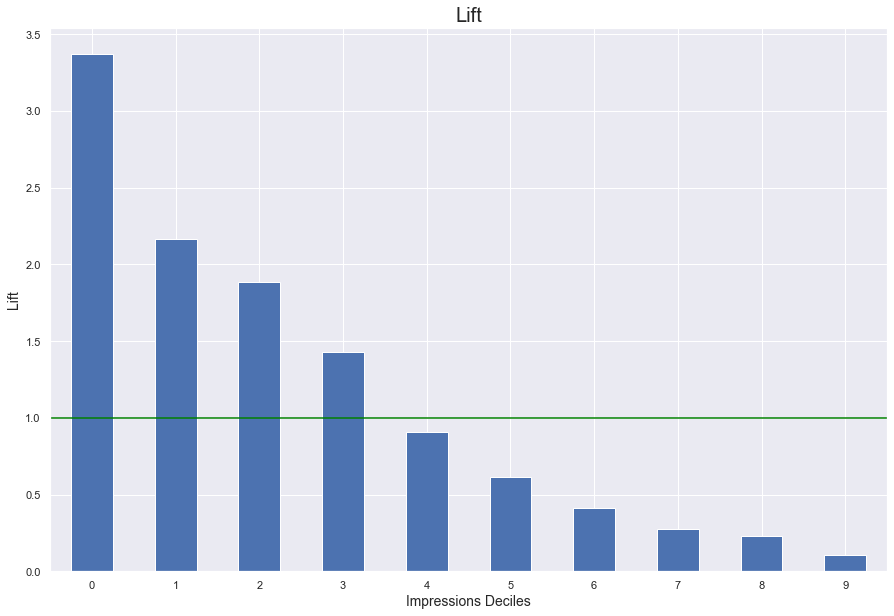

In [44]:
plt.figure(figsize=(15,10))
lift['lift'].plot(kind='bar')
plt.plot(range(-1,11),[1 for num in range(-1,11)],color='green')
plt.title('Lift',fontsize=20)
plt.xticks(rotation=0)
plt.xlabel('Impressions Deciles',fontsize=14)
plt.ylabel('Lift',fontsize=14)
plt.show()

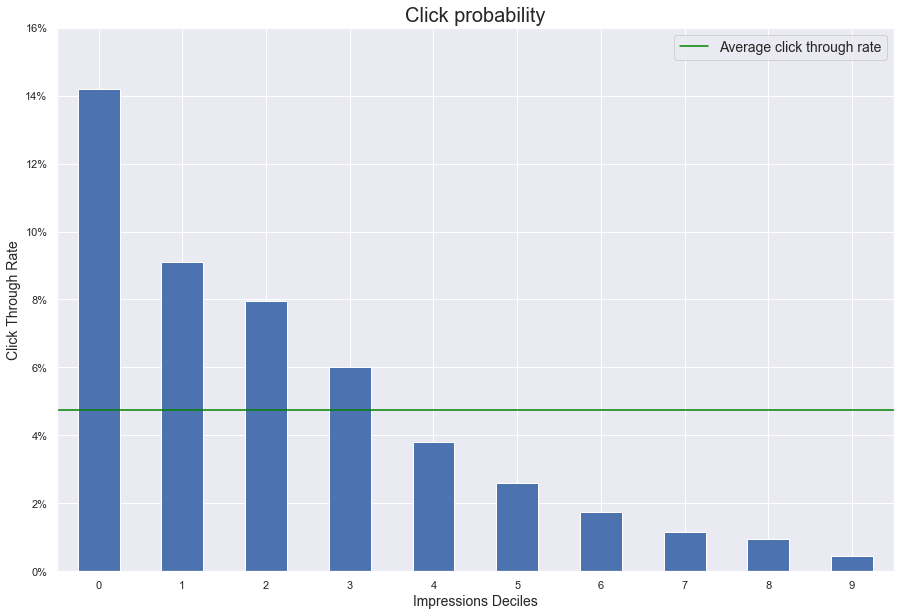

In [45]:
plt.figure(figsize=(15,10))
lift['prob_click'].plot(kind='bar',label='')
plt.plot(range(-1,11),[0.0476 for num in range(-1,11)],color='green',label='Average click through rate')
plt.title('Click probability',fontsize=20)
ticks,labels=plt.yticks()
plt.yticks(ticks,[str(int(tick*100))+'%' for tick in ticks])
plt.xticks(rotation=0)
plt.xlabel('Impressions Deciles',fontsize=14)
plt.ylabel('Click Through Rate',fontsize=14)
plt.legend(fontsize=14)
plt.show()

What does it mean?

If you remember the beginning of the post we can only sell a 30% of our banners to a premium ads provider. In this chart we can find that the average prob for the decile 3 (30%) is 6%. Every impression that our model said **the probability is higher than 6% we will sell to premium actuary**, if less than 6% to standard actuary.

![](lift_explained.png)

## Model for revenue 💰

How good is our model in terms of revenue? If we don't have any premium ads we will earn the less possible quantity of money allocating every ad on standard bidding. If we only have premium ads the allocation will be the best one. But we are in the middle of both scenarios. For that, we ploted the revenue for our model, a random model and a perfect model.

We call *fill rate* the percentage of ads we can allocate to premium, and depending on this parameter we **plot how good is our model and how much range to improve it has.**

In [46]:
def revenue_model(probs_df,fill_rate,model1_0,model1_1,model2_0,model2_1):    
    limit=round(len(probs_df)*fill_rate)
    
    #random model
    random_df=shuffle(probs_df)
    random2=random_df[:limit]
    random1=random_df[limit:]
    money_random2=random2['real_values'].sum()*model2_1+(len(random2)-random2['real_values'].sum())*model2_0
    money_random1=random1['real_values'].sum()*model1_1+(len(random1)-random1['real_values'].sum())*model1_0
    revenue_random=money_random1+money_random2
    
    
    
    #optimized problem
    probs_df=probs_df.sort_values(1,ascending=False)
    probs_model2_opt=probs_df[:limit]
    probs_model1_opt=probs_df[limit:]
    money_model2_opt=probs_model2_opt['real_values'].sum()*model2_1+(len(probs_model2_opt)-probs_model2_opt['real_values'].sum())*model2_0
    money_model1_opt=probs_model1_opt['real_values'].sum()*model1_1+(len(probs_model1_opt)-probs_model1_opt['real_values'].sum())*model1_0
    revenue_opt=money_model1_opt+money_model2_opt
    
    #perfect model
    probs_df=probs_df.sort_values('real_values',ascending=False)
    probs_model2_perf=probs_df[:limit]
    probs_model1_perf=probs_df[limit:]
    money_model2_perf=probs_model2_perf['real_values'].sum()*model2_1+(len(probs_model2_perf)-probs_model2_perf['real_values'].sum())*model2_0
    money_model1_perf=probs_model1_perf['real_values'].sum()*model1_1+(len(probs_model1_perf)-probs_model1_perf['real_values'].sum())*model1_0
    revenue_perf=money_model1_perf+money_model2_perf
    
    
    return revenue_random,revenue_opt,revenue_perf

In [47]:
#invented prices (provider 2 is premium provider)
provider1_1=0.5
provider1_0=0.0024
provider2_1=5
provider2_0=0.015
revenue_random,revenue_opt,revenue_perf=revenue_model(probs_df,0.3,provider1_0,provider1_1,provider2_0,provider2_1)


In [48]:
print('Size of test (number of impressions):',len(probs_df))
print('Number of clicks: {}, {:0.2%}'.format(probs_df['real_values'].sum(),probs_df['real_values'].sum()/len(probs_df)))
print('Revenue with a random model: {:0.0f}$'.format(revenue_random))
print('Revenue with a our model: {:0.0f}$'.format(revenue_opt))
print('Revenue with a perfect model: {:0.0f}$'.format(revenue_perf))
print('Improvement: {:0.2%}'.format((revenue_opt-revenue_random)/revenue_random))
print('Worse than perfect (range to improve): {:0.2%}'.format((revenue_opt-revenue_perf)/revenue_perf))

Size of test (number of impressions): 207898
Number of clicks: 9900, 4.76%
Revenue with a random model: 19673$
Revenue with a our model: 35168$
Revenue with a perfect model: 50636$
Improvement: 78.76%
Worse than perfect (range to improve): -30.55%


In [49]:
rev_random=[]
rev_optimal=[]
fill_rates=[]
rev_perfect=[]
for fill_rate in range(0,110,10):
    fill_rate=fill_rate/100
    revenue_random,revenue_opt,revenue_perf=revenue_model(probs_df,fill_rate,provider1_0,provider1_1,provider2_0,provider2_1)
    rev_random.append(revenue_random)
    rev_optimal.append(revenue_opt)
    rev_perfect.append(revenue_perf)
    fill_rates.append(fill_rate)

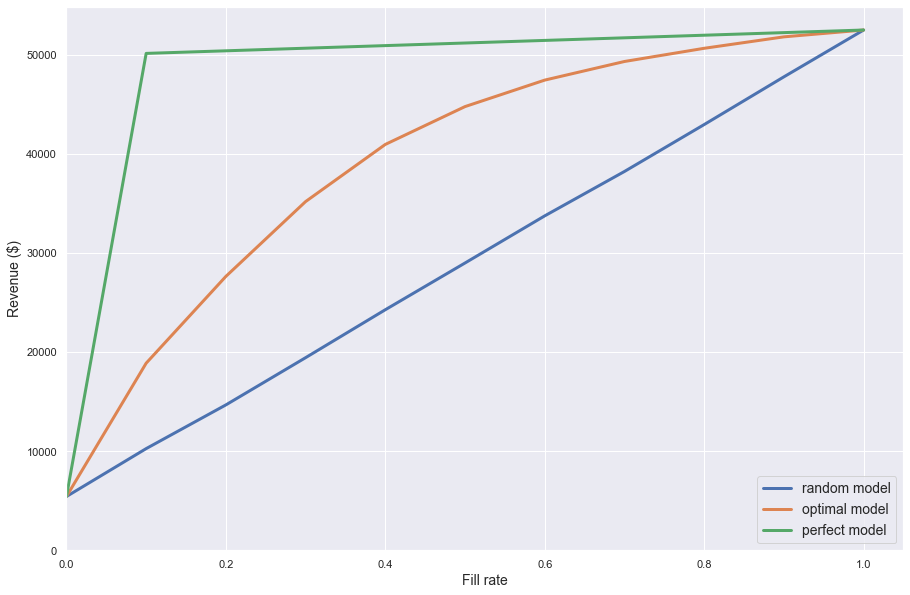

In [50]:
plt.figure(figsize=(15,10))
plt.plot(fill_rates,rev_random,label='random model',linewidth=3)
plt.plot(fill_rates,rev_optimal,label='optimal model',linewidth=3)
plt.plot(fill_rates,rev_perfect,label='perfect model',linewidth=3)
plt.legend(fontsize=14)
plt.xlabel('Fill rate',fontsize=14)
plt.ylabel('Revenue ($)',fontsize=14)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

![](model_vs_random.png)
![](model_vs_perfect.png)

## Conclusions ⚖️

Click-through prediction and programmatic advertising are complex processes but they are worth to study to improve the revenue of a website. **Models like this can duplicate your revenue from ads if you don't have any know**.

Here everything seems clean and straight forward but we spent a lot of time cleaning, diving in the data and trying different models but also **understanding which was our real goal and how to approach it** in the best possible way. Here's the distribution of our time:

![](time_spent.png)